In [ ]:
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from dm_control import suite
import matplotlib.pyplot as plt

device = torch.device("cpu")

In [52]:
# задаем ИНС Actor, так как пространство действий заключено между [-1, 1], 
# то на выходе активационной функцией будет тангенс

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()

        self.l1 = nn.Linear(state_dim, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, action_dim)

    def forward(self, state):
        a = F.relu(self.l1(state))
        a = F.relu(self.l2(a))
        return torch.tanh(self.l3(a))

# Задаем ИНС Critic, для эффективности значения action вводим сразу во второй слой
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()

        self.l1 = nn.Linear(state_dim, 400)
        self.l2 = nn.Linear(400 + action_dim, 300)
        self.l3 = nn.Linear(300, 1)


    def forward(self, state, action):
        q = F.relu(self.l1(state))
        q = F.relu(self.l2(torch.cat([q, action], 1)))
        return self.l3(q)

In [53]:
# задаем буффер в виде матрицы 1000000 х state_dim
class ReplayBuffer(object):
    def __init__(self, state_dim, action_dim, max_size=int(1e6)):
        self.max_size = max_size
        self.ptr = 0
        self.size = 0

        self.state = np.zeros((max_size, state_dim))
        self.action = np.zeros((max_size, action_dim))
        self.next_state = np.zeros((max_size, state_dim))
        self.reward = np.zeros((max_size, 1))
        self.not_done = np.zeros((max_size, 1))

        self.device = torch.device("cpu")

    def add(self, state, action, next_state, reward, done):
        self.state[self.ptr] = state
        self.action[self.ptr] = action
        self.next_state[self.ptr] = next_state
        self.reward[self.ptr] = reward
        self.not_done[self.ptr] = 1. - done
        
        # при переполнении буфера строки матрицы перезаписываются
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size):
        ind = np.random.randint(0, self.size, size=batch_size)

        return (
            torch.FloatTensor(self.state[ind]).to(self.device),
            torch.FloatTensor(self.action[ind]).to(self.device),
            torch.FloatTensor(self.next_state[ind]).to(self.device),
            torch.FloatTensor(self.reward[ind]).to(self.device),
            torch.FloatTensor(self.not_done[ind]).to(self.device)
        )

In [ ]:
class DDPG(object):
    def __init__(self, state_dim, action_dim, max_action, discount=0.99, tau=0.005):
        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target = copy.deepcopy(self.actor)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=1e-4)

        self.critic = Critic(state_dim, action_dim).to(device)
        self.critic_target = copy.deepcopy(self.critic)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),lr=1e-4)

        self.discount = discount
        self.tau = tau


    def select_action(self, state):
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        return self.actor(state).cpu().data.numpy().flatten()


    def train(self, replay_buffer, batch_size):
        # формируем батч
        state, action, next_state, reward, not_done = replay_buffer.sample(batch_size)

        # Считаем target Q value
        target_Q = self.critic_target(next_state, self.actor_target(next_state))
        target_Q = reward + (not_done * self.discount * target_Q).detach()

        # Считаем current Q value
        current_Q = self.critic(state, action)

        # Считаем разницу
        critic_loss = F.mse_loss(current_Q, target_Q)

        # обновляем веса critic
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Считаем ошибку actor
        actor_loss = -self.critic(state, self.actor(state)).mean()

        # обновляем веса actor
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Обновляем веса target
        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

        for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

In [54]:
# функция для формирования вектора state
def get_state(observation):
    return np.hstack(
        [observation['joints'], observation['to_target'], observation['body_velocities']]
    ).reshape((1,25))

In [57]:
env = suite.load(domain_name="swimmer", task_name="swimmer6")

In [58]:
# гипер-параметры
state_dim = 25
action_dim = env.action_spec().shape[0]
min_action = float(env.action_spec().minimum[0])
max_action = float(env.action_spec().maximum[0])
action_shape = env.action_spec().shape
batch_size = 256
expl_noise = 1

In [59]:
kwargs = {
        "state_dim": state_dim,
        "action_dim": action_dim,
        "max_action": max_action,
        "discount": discount,
        "tau": tau,
    }
policy = DDPG(**kwargs)
replay_buffer = ReplayBuffer(state_dim, action_dim)

In [62]:
# Инициация
state_type, reward, discount, obs = env.reset()
state = get_state(obs)
done = False
first_step = True
episode_reward = 0
episode_num = 0
result = list()
rewards = list()

In [243]:
while True:
#     коэффициент для Exploration
    if expl_noise > 0.1:
        expl_noise = 1 - episode_num/100
    # Первые 10 эпизодов выбираем случайные действия и заполняем буфер
    if episode_num < 10:
        action = np.random.uniform(low=min_action, high=max_action, size=action_shape)
#     Далее считаем action и прибавляем к нему нормальный шум
    else:
        action = (
            policy.select_action(state)
            + np.random.normal(0, max_action * expl_noise, size=action_dim)
        ).clip(-max_action, max_action)
        
    # Выполняем action
    step_type, new_reward, discount, next_obs = env.step(action)
    next_state = get_state(next_obs)
    done = step_type.last()
#     Для первого шага в эпизоде ревард равен 0, 
#     для последующих ревард рассчитывается, как разность между текущим ревардом и предыдущим 
    if first_step:
        reward = 0
        first_step = False
    else:
        reward = (new_reward - old_reward) * 1000
    
    # сохраняем в буфер
    replay_buffer.add(state, action, next_state, reward, done)
    
    old_reward = new_reward
    state = next_state
    episode_reward += reward

    # Обучаем ИНС
    if episode_num >= 10:
        policy.train(replay_buffer, batch_size)
    
    if done:
        # после завершения эпизода обновляем окружение
        print(f"Episode Num: {episode_num+1} Reward: {episode_reward:.3f} dif: {np.mean(rewards)}")
        state_type, reward, discount, obs = env.reset()
        state = get_state(obs)
        done = False
        result.append(episode_reward)
        episode_reward = 0
        episode_num += 1
        first_step = True


Episode Num: 13439 Reward: 896.581 dif: 1.091377285608349
Episode Num: 13440 Reward: 0.000 dif: 1.091377285608349
Episode Num: 13441 Reward: 70.526 dif: 1.091377285608349
Episode Num: 13442 Reward: 259.229 dif: 1.091377285608349
Episode Num: 13443 Reward: 965.354 dif: 1.091377285608349
Episode Num: 13444 Reward: 0.629 dif: 1.091377285608349
Episode Num: 13445 Reward: 2.900 dif: 1.091377285608349
Episode Num: 13446 Reward: 473.276 dif: 1.091377285608349
Episode Num: 13447 Reward: 2.747 dif: 1.091377285608349
Episode Num: 13448 Reward: 985.855 dif: 1.091377285608349
Episode Num: 13449 Reward: 946.575 dif: 1.091377285608349
Episode Num: 13450 Reward: 978.532 dif: 1.091377285608349
Episode Num: 13451 Reward: 919.530 dif: 1.091377285608349
Episode Num: 13452 Reward: -0.829 dif: 1.091377285608349
Episode Num: 13453 Reward: 972.657 dif: 1.091377285608349
Episode Num: 13454 Reward: 950.284 dif: 1.091377285608349
Episode Num: 13455 Reward: 986.403 dif: 1.091377285608349
Episode Num: 13456 Rewar

KeyboardInterrupt: 

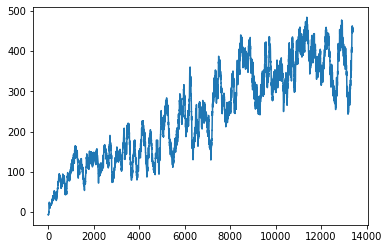

In [244]:
# среднее значение измененного ревардов за последние 100 эпизодов
plt.plot([np.mean(result[x-100:x]) for x in range(100, len(result))])
plt.show()

In [260]:
# тестируем политику
test_score = list()
for i in range(100):
    state_type, reward, discount, obs = env.reset()
    state = get_state(obs)
    done = False 
    episode_rewards = 0
    
    while not done:
        action = policy.select_action(state)
        step_type, reward, discount, next_obs = env.step(action)
#         print(reward)
        next_state = get_state(next_obs)
        done = step_type.last()
        episode_rewards += reward
        state = next_state
        
        
    print(f"Episode Num: {i+1} Reward: {episode_rewards}")
    test_score.append(episode_rewards)

Episode Num: 1 Reward: 526.528084809193
Episode Num: 2 Reward: 992.6351151111318
Episode Num: 3 Reward: 34.67275674227441
Episode Num: 4 Reward: 5.354240390106445
Episode Num: 5 Reward: 4.872219567843945
Episode Num: 6 Reward: 11.022463873633667
Episode Num: 7 Reward: 973.7379810562037
Episode Num: 8 Reward: 616.3074710409574
Episode Num: 9 Reward: 996.5586903484452
Episode Num: 10 Reward: 998.6880368401928
Episode Num: 11 Reward: 698.9734389204098
Episode Num: 12 Reward: 412.3452065203353
Episode Num: 13 Reward: 990.3518245125676
Episode Num: 14 Reward: 618.743668467407
Episode Num: 15 Reward: 6.150999090546646
Episode Num: 16 Reward: 988.8312483126205
Episode Num: 17 Reward: 936.7785850775559
Episode Num: 18 Reward: 890.0123143532937
Episode Num: 19 Reward: 673.2362961643069
Episode Num: 20 Reward: 9.106073093502514
Episode Num: 21 Reward: 8.585465150723431
Episode Num: 22 Reward: 987.890690856088
Episode Num: 23 Reward: 846.1905059228499
Episode Num: 24 Reward: 11.759311440911711
Ep

In [266]:
a = len([x for x in test_score if x < 0])
b = len([x for x in test_score if 0 <= x < 100])
c = len([x for x in test_score if 100 <= x < 900])
d = len([x for x in test_score if x > 900])

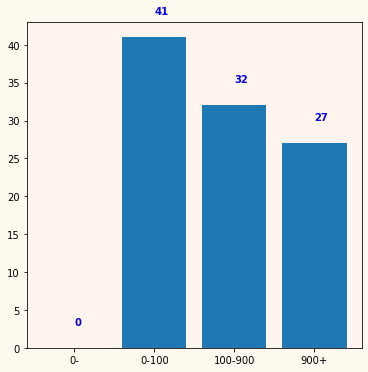

In [267]:
x = ['0-', '0-100', '100-900', '900+']
y = [a, b, c, d]

fig, ax = plt.subplots()

ax.bar(x, y)

ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(6)
fig.set_figheight(6)

for i, v in enumerate(y):
    ax.text(i, v + 3, str(v), color='blue', fontweight='bold')

plt.show()

Визуализация

In [268]:
from dm_control import viewer
def random_policy(time_step):
    state_type, reward, discount, obs = time_step
    state = get_state(obs)
    action = policy.select_action(state)
#     print(reward)
    return action
viewer.launch(env, policy=random_policy)